In [1]:
pip install rouge

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install transformers[torch] datasets -q

from google.colab import drive
drive.mount('/content/drive')

In [3]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os

2024-05-08 18:50:10.086937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 18:50:10.087032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 18:50:10.224032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import json
json_file_path = '/kaggle/input/final-vqa-data/Final data All Week.json'

with open(json_file_path, 'r') as file:
    dataset = json.load(file)


In [6]:
def load_image(image_path, base_path='/kaggle/input/final-vqa-data/all_slides - Copy'):
    full_path = os.path.join(base_path, image_path)
    image = Image.open(full_path).convert('RGB')  # Ensure RGB format
    return image


In [7]:
import pandas as pd
df = pd.read_json(json_file_path)
print(df.head())


                                         instruction  \
0  What operations were mentioned in last week's ...   
1         What was the focus of last week's lecture?   
2  What did last week's lecture mention about noi...   
3   What topics were covered in last week's lecture?   
4  What are some possible reasons for noise in im...   

                                            response                category  \
0  Last week's lecture mentioned operations such ...  information_extraction   
1  The focus of last week's lecture was on discus...               closed_qa   
2  Last week's lecture briefly mentioned the pres...               closed_qa   
3  Last week's lecture covered image representati...              general_qa   
4  Possible reasons for noise in images include l...  information_extraction   

   week  page                                            context  
0     3     2  The transcript discusses the operations covere...  
1     3     2  The transcript provides informati

## Sample Visualization

In [8]:
def construct_image_path(sample, base_path='/kaggle/input/final-vqa-data/all_slides - Copy'):
    image_file_name = f"week_{str(sample['week']).zfill(2)}_page_{str(sample['page']).zfill(3)}.png"
    return os.path.join(base_path, image_file_name)


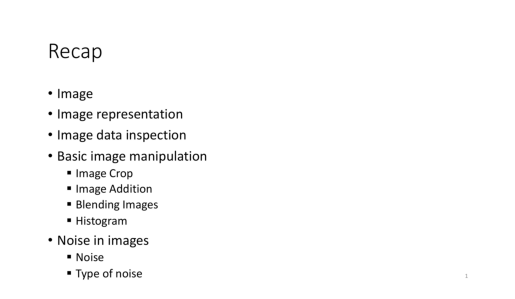

Question: What was the focus of last week's lecture?
Answer: The focus of last week's lecture was on discussing image representation, data inspection, and basic image manipulation operations.


In [9]:
import os
sample_index = 1
sample = dataset[sample_index]

image_path = construct_image_path(sample)

image = Image.open(image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')
plt.show()
print("Question: {}".format(sample['instruction']))
print("Answer: {}".format(sample['response']))


In [10]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

## Build Data-loader

In [11]:
import torch
from PIL import Image
import os
from transformers import CLIPProcessor, CLIPModel, BlipProcessor, BlipImageProcessor

# Initialize the processors and models
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, text_processor, image_processor):
        self.data = data
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 224  # Ensure this matches CLIP's requirements
        self.image_width = 224

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        instruction = sample['instruction']
        response = sample['response']
        image_path = self.construct_image_path(sample)
        image = Image.open(image_path).convert('RGB')
        image = image.resize((self.image_width, self.image_height))

        # Process image with CLIP-specific processor for correct tokenization and normalization
        image_encoding = clip_processor(images=image, return_tensors="pt")

        # Process text with BLIP text processor
        text_encoding = text_processor(text=instruction, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")

        # Encode labels using the BLIP tokenizer
        labels = text_processor.tokenizer.encode(response, max_length=self.max_length, padding="max_length", truncation=True, return_tensors='pt')[0]

        return {
            'input_ids': text_encoding['input_ids'].squeeze(),
            'attention_mask': text_encoding['attention_mask'].squeeze(),
            'pixel_values': image_encoding['pixel_values'].squeeze(),
            'labels': labels
        }

    def construct_image_path(self, sample):
        base_path = '/kaggle/input/final-vqa-data/all_slides - Copy'
        image_file_name = f"week_{str(sample['week']).zfill(2)}_page_{str(sample['page']).zfill(3)}.png"
        return os.path.join(base_path, image_file_name)


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [12]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create VQADataset instances for training and validation
train_vqa_dataset = VQADataset(train_dataset, text_processor, image_processor)
val_vqa_dataset = VQADataset(val_dataset, text_processor, image_processor)


In [13]:
train_vqa_dataset[0]

{'input_ids': tensor([ 101, 2054, 2024, 2070, 3145, 2685, 4953, 1996, 5197, 1998, 5097, 1997,
         3746, 6364, 2004, 2649, 1999, 1996, 3793, 1029,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'pixel_values': tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],
 
         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
    

In [14]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=16,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=16,
                            shuffle=False)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([16, 32])
attention_mask torch.Size([16, 32])
pixel_values torch.Size([16, 3, 224, 224])
labels torch.Size([16, 32])


## Build Model

In [16]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
model.to(device)

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] how does the dimensionality of data impact machine learning algorithms? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] the dimensionality of data affects machine learning algorithms by influencing their complexity, performance, and ability to generalize from the training data to unseen examples, with [SEP]


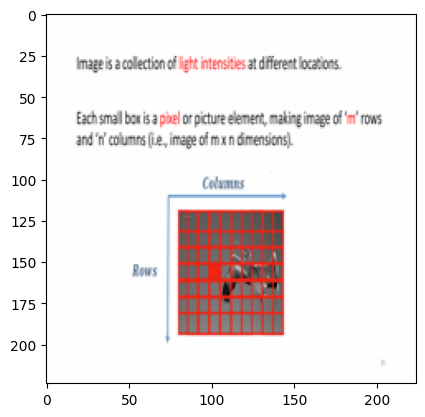

In [18]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

## Model Training

In [19]:
model.train()
for epoch in range(10):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

Epoch: 0


  0%|          | 0/540 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 1970.38116979599
Epoch: 1


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 1233.327431321144
Epoch: 2


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 926.5995737314224
Epoch: 3


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 723.5684653520584
Epoch: 4


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 566.651428937912
Epoch: 5


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 426.26971808075905
Epoch: 6


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 311.47014531493187
Epoch: 7


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 227.806327059865
Epoch: 8


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 165.76416175067425
Epoch: 9


  0%|          | 0/540 [00:00<?, ?it/s]

Loss: 123.16865099966526


## Inference

Question:  what is the speaker's opinion about perceiving the difference?


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  the speaker acknowledges that if there is a wider field of view, it may not be more effective
Actual Answer:  the speaker acknowledges that it's very difficult to perceive the difference.


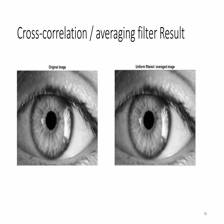

###################################################################
Question:  how are the scales'sk'determined for each default box?
Predicted Answer:  for scale - invariant components, the aspp can be adjusted based on the distribution of object scales
Actual Answer:  the scales'sk'are computed using a formula that takes into account the size of the feature map and the desired number of default boxes to cover various


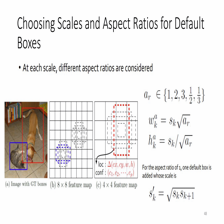

###################################################################
Question:  what is an fcn and what does it do?
Predicted Answer:  an operator or kernel in fcn can be extended for more accurate convolution operations,
Actual Answer:  a fully convolutional network ( fcn ) is a type of neural network designed for semantic image segmentation. it processes images on a


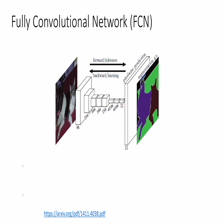

###################################################################
Question:  how might one mitigate the occurrence of spurious patterns in hierarchical clustering results?
Predicted Answer:  one limitation of the spreadoff function could be its sensitivity to noise reduction, particularly in the context
Actual Answer:  mitigating spurious patterns in hierarchical clustering results can involve carefully selecting appropriate distance measures, preprocessing data to remove noise, and valid


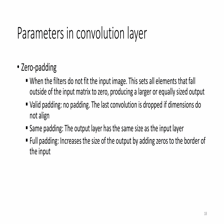

###################################################################
Question:  how does the transcript convey the concept of'tasking'in relation to the use of robots?
Predicted Answer:  the transcript mentions the need for adaptability in the context of'more than the input ',
Actual Answer:  the transcript mentions the concept of'tasking'in relation to the use of robots. understanding how robots are employed for specific tasks and the significance of


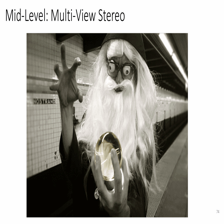

###################################################################
Question:  are there any limitations to using yolo and ssd for object detection?
Predicted Answer:  while there is a potential issue in yolo's architecture, there is a misconception
Actual Answer:  some limitations of yolo include difficulties in detecting small objects due to spatial constraints, while ssd might struggle with a high class imbalance in dataset


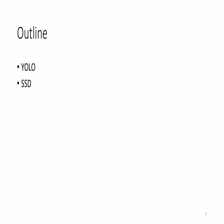

###################################################################
Question:  how does the presence of noise impact the accuracy of edge detection algorithms?
Predicted Answer:  the presence of noise interference in edge detection can be influenced by the presence of noise in the image
Actual Answer:  the presence of noise can significantly impact the accuracy of edge detection algorithms by introducing false features and artifacts. noise can obscure true edges, leading to errors in


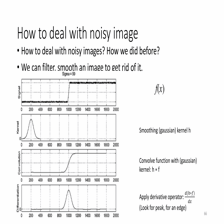

###################################################################
Question:  what challenges might arise when implementing scenario 1 of transfer learning?
Predicted Answer:  considerations in implementing transfer learning with an independent component, as it may not be suitable for the data
Actual Answer:  challenges in implementing scenario 1 of transfer learning might include difficulties in tuning the final layers to effectively adapt to new tasks, potential mismatches between the feature


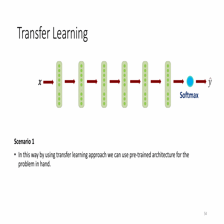

###################################################################
Question:  what is the operation mentioned in the transcript?
Predicted Answer:  the operation described in the transcript is considered a'operation operation,'where it focuses on developing
Actual Answer:  the operation mentioned in the transcript is the removal of noise from an image.


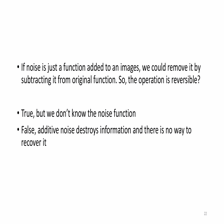

###################################################################
Question:  what is the purpose of applying the gradient threshold in keypoint localization?
Predicted Answer:  the purpose of applying gradient thresholding in the keypoint detection algorithm is to determine whether it is
Actual Answer:  the gradient threshold is applied to filter out keypoints that do not meet a certain gradient criterion, helping to refine the selection of keypoints based on


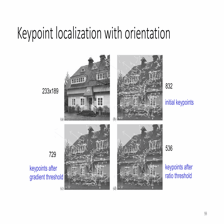

###################################################################
Question:  can you summarize the key steps and decision points involved in the bottom - up ( agglomerative ) clustering algorithm as explained?
Predicted Answer:  the bottom - up algorithm, as described, involves several key steps, including taking an input image
Actual Answer:  the bottom - up clustering algorithm starts with each item in its own cluster and iteratively merges pairs of clusters into new clusters, considering all


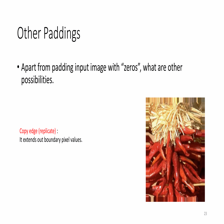

###################################################################
Question:  which image format supports animations and simple transitions?
Predicted Answer:  gradient descent, as described in the transcript, may involve more effective for more accurate convolu
Actual Answer:  gif ( graphics interchange format ) supports animations and simple transitions by allowing multiple frames within a single file. it is commonly used for web graphics,


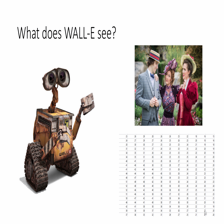

###################################################################
Question:  how might the use of an image pyramid enhance the performance of image classification algorithms?
Predicted Answer:  the effectiveness of an image pyramid, as this method, can be improved in reducing the image '
Actual Answer:  image pyramids offer a hierarchical structure that allows image classifiers to analyze images at multiple scales, capturing both fine and coarse details. this enhances the


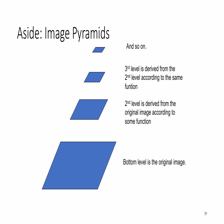

###################################################################
Question:  can you explain how machine learning techniques are applied in 3d animation?
Predicted Answer:  in machine learning, 2d gradients are used in dimensionality reduction techniques to better represent the distribution
Actual Answer:  machine learning techniques are applied in 3d animation for tasks such as character animation, motion capture, facial expression recognition, and generating realistic movement patterns, leveraging


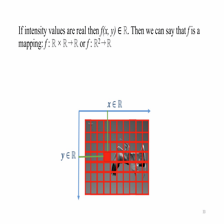

###################################################################
Question:  what is mentioned as a potential method for removing noisy from images?
Predicted Answer:  a mathematical operation involving transposed convolution is a more effective alternative to the traditional con
Actual Answer:  using a filter with a suppressor is mentioned as a potential method.


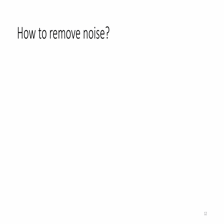

###################################################################
Question:  explain the concept of pixel categorization in threshold - based image processing.
Predicted Answer:  in transposed convolution, the function of'f'thresholding, as described
Actual Answer:  pixel categorization in threshold - based image processing involves assigning pixels to specific values ( e. g., 0 or 255 ) based on whether


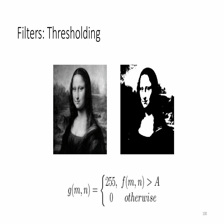

###################################################################
Question:  how does the test time per image with selective search compare between r - cnn and fast r - cnn?
Predicted Answer:  the forward propagation time, as faster r - cnn, has a significant reduction in fps,
Actual Answer:  with selective search, r - cnn takes 50 seconds per image, whereas fast r - cnn takes only 2 seconds per image.


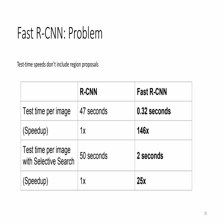

###################################################################
Question:  what is histogram equalization in image processing?
Predicted Answer:  in transposed convolution, the histogram equalization can be used to improve
Actual Answer:  histogram equalization in image processing is a technique used to enhance the contrast of an image by adjusting its intensity distribution. the process redistri


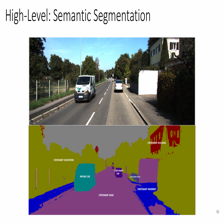

###################################################################
Question:  how is noise reduction described in the transcript?
Predicted Answer:  noise reduction is considered beneficial in the described method of denoising gradient magnitude, as it helps
Actual Answer:  the transcript describes noise reduction by suggesting the replacement of pixel values with their average.


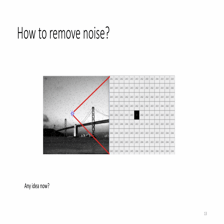

###################################################################
Question:  what concept in image processing does the discussion about scaling the operator relate to?
Predicted Answer:  the discussion suggests that increasing the parameter distribution in image processing, particularly in terms of capturing finer details
Actual Answer:  the discussion about scaling the operator relates to the concept of normalization in image processing. normalization ensures that the values of the operator are adjusted to maintain


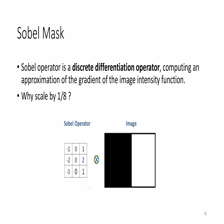

###################################################################
Question:  what is there in this slide?
Predicted Answer:  the objective function of in transfer learning is to adjust the covariance matrix used in the un
Actual Answer:  principal component analysis ( pca ) is a statistical technique used for dimensionality reduction and data visualization. by analyzing the variance and relationships between variables in


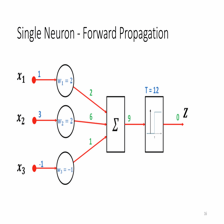

###################################################################
Question:  what is the role of contrast in digital images?
Predicted Answer:  the relationship between gradient magnitude, unsharp masking, and other edge detection techniques can be
Actual Answer:  the role of contrast in digital images is to define the range of brightness levels and the difference between light and dark areas. contrast affects the visual impact of


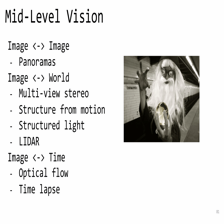

###################################################################
Question:  describe the steps to fine - tune a pre - trained network for a new classification task with a small dataset.
Predicted Answer:  for a pre - trained model, one could use a residual network for backpropagation,
Actual Answer:  to fine - tune a pre - trained network for a new classification task with a small dataset, one should start by selecting a suitable pre - trained


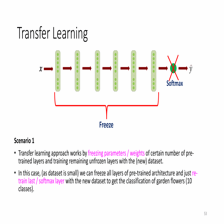

###################################################################
Question:  discuss the effectiveness of using a well - known cultural reference in the academic naming of a technological tool.
Predicted Answer:  the use of a more effective operator in a broader field of mathematical analysis can be significant because it
Actual Answer:  using a well - known cultural reference, such as the movie'inception ', in the academic naming of a technological tool like a neural network can be


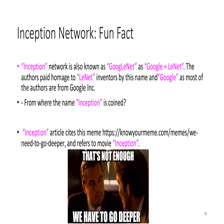

###################################################################
Question:  are we going to cover any specific algorithms in depth during this lecture?
Predicted Answer:  yes, if the lecture is overlaying data with uniform convolution, it may
Actual Answer:  today's lecture will likely go into depth on specific object detection algorithms, possibly covering advancements in models like yolo or faster r - cnn.


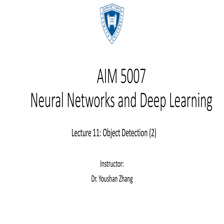

###################################################################
Question:  in what scenarios might the combination of box and class predictions be less accurate?
Predicted Answer:  in certain fields, the combination of box regression could be adapted by incorporating additional predictions for different classes
Actual Answer:  the combination might be less accurate in scenarios with heavy occlusion, similar - looking objects, or poor - quality images that make it difficult for yo


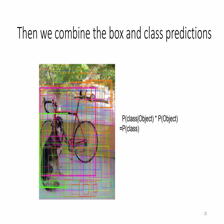

###################################################################
Question:  what is highlighted regarding the relationship between'alpha'and the resulting sharpening image?
Predicted Answer:  the conversation emphasizes the relationship between the'alpha'function, which is used in relation to the
Actual Answer:  the relationship between'alpha'and the resulting sharpening image is highlighted in terms of the direct influence of'alpha'on the degree of detail enhancement


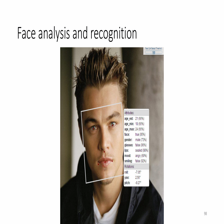

###################################################################
Question:  what is the role of the notion function as discussed in the transcript?
Predicted Answer:  the function of the gaussian function in the discussed operation is used to divide the dataset
Actual Answer:  the transcript discusses the notion function in the context of gaussian functions and their approximation.


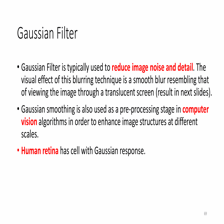

###################################################################
Question:  can you explain the differences between the various gradient kernels mentioned in the text?
Predicted Answer:  the transcript mentions that there is a different distribution of gradient kernels, as well as a discussion
Actual Answer:  the various gradient kernels mentioned in the text differ in their arrangement of weights, which determines how they compute the gradient of an image. for example,


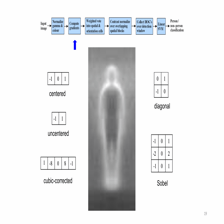

###################################################################
Question:  who is teaching lecture 7 on convolution neural networks in the aim 5007 course?
Predicted Answer:  for lecture 7, the instructor could use the visual aids effectively, specifically interactive with the broader field
Actual Answer:  dr. youshan zhang is the instructor teaching lecture 7 on convolution neural networks in the aim 5007 course.


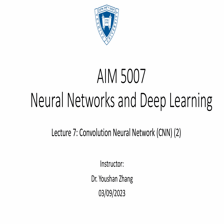

###################################################################
Question:  what is the significance of discussing edge detection in the next week?
Predicted Answer:  discussing gradient direction in the discussion may help in understanding the edge detection algorithm's behavior. if
Actual Answer:  discussing edge detection may provide insights into how it can be applied using simple image kernels.


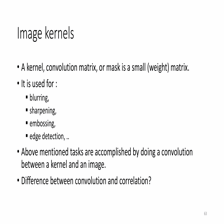

###################################################################
Question:  how does gaussian filtering differ from non - linear filtering in noise removal?
Predicted Answer:  in transposed convolution, gaussian filtering may not effectively remove noise from the
Actual Answer:  gaussian filtering may not effectively remove noises that do not follow gaussian distribution, necessitating the use of non - linear filtering for such


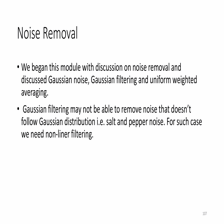

###################################################################
Question:  how does the roi pooling method shown improve model training?
Predicted Answer:  the formula for pooling in the if - not adjusting feature transformer can be applied to more
Actual Answer:  roi pooling streamlines the model training by ensuring that only the most relevant sections of an image are processed. by focusing on regions likely to contain objects


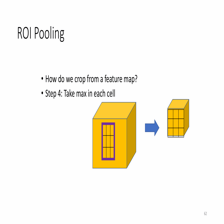

###################################################################
Question:  what are the technical requirements for implementing instance segmentation as shown in the urban scene?
Predicted Answer:  the crucial considerations discussed in implementing partial derivatives with respect to x, including the need for separate con
Actual Answer:  technical requirements for implementing instance segmentation include robust algorithms capable of processing complex visual data, high computational power to handle real - time analysis, and sophisticated models


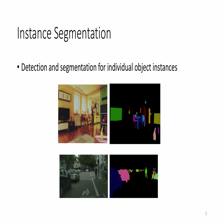

###################################################################
Question:  how does yolo divide the input image for processing?
Predicted Answer:  in yolo's grid - based approach, there can be two separate components : convo
Actual Answer:  yolo divides the input image into an s x s grid for processing, with each grid cell responsible for predicting objects that fall within it.


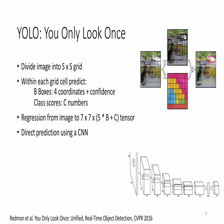

###################################################################
Question:  categorize the shift in technology from handcrafted features to convnets based on the imagenet results.
Predicted Answer:  the shift - and - stitch approach in machine learning could involve several advantages, including the desired con
Actual Answer:  the shift in technology from handcrafted features to convolutional neural networks ( convnets ) as depicted in the imagenet results can


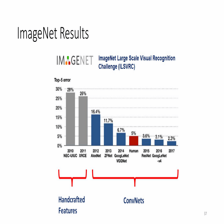

###################################################################
Question:  what is notable about median filtering compared to averaging?
Predicted Answer:  the advantage of parallelizing gradient histograms in the presence of more convolution
Actual Answer:  median filtering differs from averaging by selecting the median value, which helps in removing spikes and extreme values from the neighborhood.


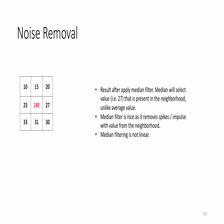

###################################################################
Question:  how are default boxes sorted in hard negative mining?
Predicted Answer:  in deeper convolution, the output dimensions are adjusted based on the application of'f
Actual Answer:  default boxes are sorted by the highest confidence loss, which indicates the level of error in the model's predictions for each box.


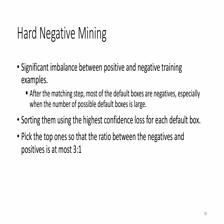

###################################################################
Question:  describe how roi pooling enhances object detection models.
Predicted Answer:  pooling techniques that enhance feature extraction in convolutional layers can be adapted for more
Actual Answer:  roi pooling enhances object detection models by providing a mechanism to extract fixed - size feature vectors from variable - sized bounding boxes, ensuring that features


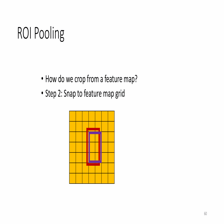

###################################################################
Question:  what does the parameter'r'signify in atrous convolution?
Predicted Answer:  the parameter'r'represents the rate of atrous convolution with a higher parameter
Actual Answer:  in atrous convolution, the parameter'r'represents the rate or dilation factor, which determines the stride with which the input is


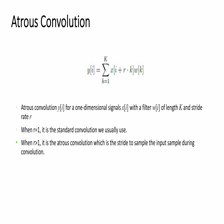

###################################################################
Question:  how does the transcript relate to the uav and its applications?
Predicted Answer:  the transcript mentions the combination of unsharp masking with the nearest neighbor matrix, specifically involving
Actual Answer:  the transcript discusses the uav and its applications, providing insights into its role, tools, and ongoing research, particularly in detection and problem - solving.


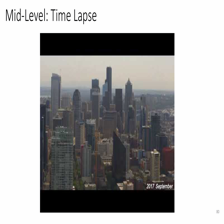

###################################################################
Question:  how would yolo use the confidence score p ( object ) in the context of this image?
Predicted Answer:  the confidence score p ( object ) can be adjusted to determine whether an object is partially obscured by
Actual Answer:  yolo would use the confidence score p ( object ) to quantify the likelihood that each predicted bounding box accurately contains an object. a higher score


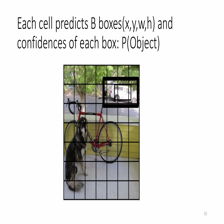

###################################################################
Question:  list the requirements for project two as described in the slide.
Predicted Answer:  the project proposal generation, particularly those with more than the entire input, can be beneficial for implementing
Actual Answer:  the requirements for project two include building an object detection model using pytorch, training it with cow stall number datasets, evaluating the model


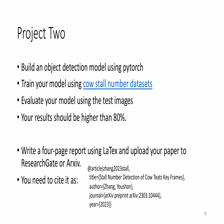

###################################################################
Question:  what is emphasized as very important for edges in the transcript?
Predicted Answer:  the transcript suggests that gradient magnitude is considered very important for edges.
Actual Answer:  the transcript emphasizes that gradient magnitude is very important for edges.


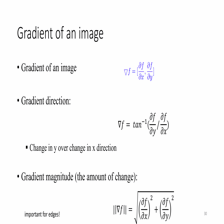

###################################################################
Question:  what is the role of algorithms in filtering?
Predicted Answer:  in transposed convolution, the operation of dilation techniques, like dilation with
Actual Answer:  algorithms are applied to the values of pixels in the neighborhood of each input pixel to determine the value of the corresponding output pixel during filtering.


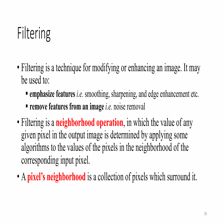

###################################################################
Question:  why does the precision decrease as recall increases in this graph?
Predicted Answer:  the precision threshold can be adjusted based on the specific requirements of the dataset, where the model
Actual Answer:  precision decreases as recall increases because the model starts to include more potential true positives, increasing the risk of false positives. this trade - off is


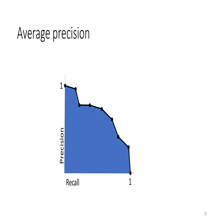

###################################################################
Question:  explain the key steps involved in the canny edge detection process as outlined in the transcript.
Predicted Answer:  the conversation outlines several steps of the convolutional layer, including applying a linear filter
Actual Answer:  the transcript outlines the key steps of the canny edge detection process. firstly, the image is convolved with the derivative of gaussian filter


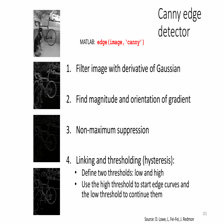

###################################################################
Question:  what is the concept of a'half plane'discussed in the transcript?
Predicted Answer:  a'half plane'is defined as a straight line in a 2d image, where it is
Actual Answer:  the concept of a'half plane'refers to a space whose dimension is one less than the ambient space. for example, in a 2d space,


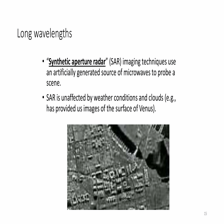

###################################################################
Question:  what is the significance of image addition in digital image processing?
Predicted Answer:  the significance of image gradient calculation in digital image processing is that it provides a simple method for downs
Actual Answer:  the significance of image addition in digital image processing is that it allows for combining pixel values from two or more images to create a new image. this operation


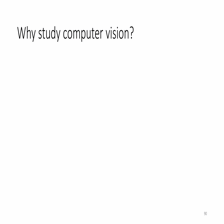

###################################################################
Question:  what is the size of the matrix mentioned in the transcript?
Predicted Answer:  the matrix m has an inverse matrix, specifically used for matrix factorization, is considered for more
Actual Answer:  the size of the matrix mentioned in the transcript is specified as'3 by 3,'indicating a matrix with 3 rows and 3 columns.


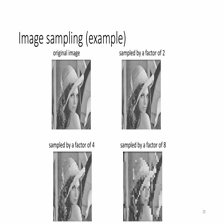

###################################################################
Question:  what are some common applications of vector space scaling?
Predicted Answer:  gradient descent, particularly in the context of pca, is particularly useful in tasks such as dimensional
Actual Answer:  vector space scaling is used in various applications such as principal component analysis ( pca ), spectral clustering, feature scaling in machine learning, and geometric


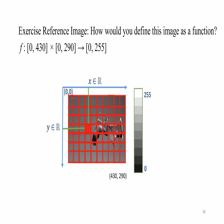

###################################################################
Question:  how does the transcript exemplify the application of visual perception in computational tasks?
Predicted Answer:  the transcript suggests improving the spread of gaussian functions in image processing by incorporating additional mechanisms for
Actual Answer:  this demonstrates the application of visual perception in computational tasks through the participants'engagement in identifying directional features, showcasing the integration of human perception with machine analysis.


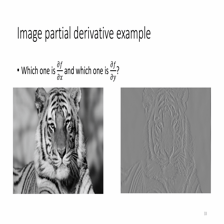

###################################################################
Question:  what is the significance of identifying stable features across multiple scales in scale - space extrema detection?
Predicted Answer:  identifying stable features in the sift algorithm can help improve the model's ability to detect objects
Actual Answer:  identifying stable features across multiple scales is significant as it allows for the detection of keypoints that are robust to changes in viewpoint, scale, and illumination,


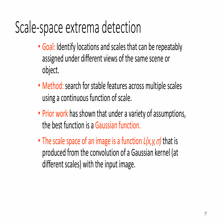

###################################################################
Question:  explain what the graph on this slide represents.
Predicted Answer:  the graph represents the variability in the distribution of datasets by comparing the'f'-
Actual Answer:  the graph shows the mean average precision ( ap ) scores for different versions of the r - cnn family of object detection models. it traces improvements from r


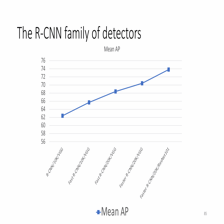

###################################################################
Question:  why is similarity considered hard to define, according to the context?
Predicted Answer:  gradient descent is considered beneficial in the context of unsupervised learning, where it may
Actual Answer:  similarity is considered hard to define because it can be subjective and context - dependent. however, the context suggests that despite this difficulty, people often intuitively


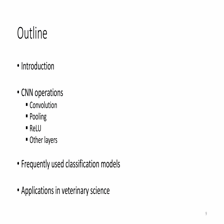

###################################################################
Question:  how does an unsharp mask affect the contrast of an image?
Predicted Answer:  an unsharp mask can be used in image processing for more effective edge detection, as it
Actual Answer:  an unsharp mask affects the contrast of an image by emphasizing the differences between the original and the blurred version. this technique creates a mask that,


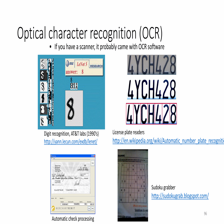

###################################################################
Question:  what does the softmax layer do in this convnet?
Predicted Answer:  the softmax layer in transposed convolution is used to adjust the distribution of the
Actual Answer:  the softmax layer in this convnet takes the outputs from the last fully connected layer ( fc4 ) and converts them into probability scores representing the


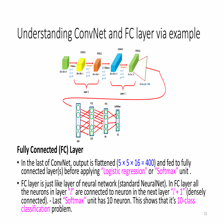

###################################################################
Question:  what are the main components of the image gradient computation process as outlined in the text?
Predicted Answer:  the main components of the gradient kernel discussed in the transcript include the use of convolution
Actual Answer:  the text outlines the process of computing the image gradient, which involves kernel convolution to determine both magnitude and angle components. the magnitude represents the


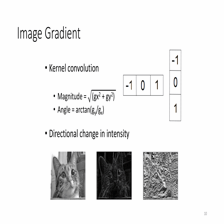

###################################################################
Question:  how does the course emphasize the importance of projects versus homework?
Predicted Answer:  the course prepares students for the practical application of pytorch for the course, specifically through
Actual Answer:  the course places a stronger emphasis on projects, which make up 70 % of the final grade ( 40 % for three projects and 30 % for the final


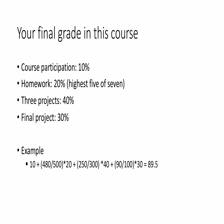

###################################################################
Question:  how does vector manipulation contribute to spectral clustering algorithms?
Predicted Answer:  gradient descent, particularly in the context of unsharp masking, is crucial for improving the
Actual Answer:  in spectral clustering algorithms, vector manipulation techniques such as scaling and normalization are employed to preprocess data and construct similarity matrices, enabling the


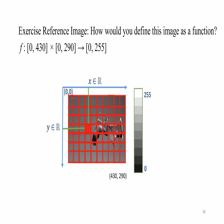

###################################################################
Question:  what challenges or considerations might be associated with the segmentation of white matter or gray matter mentioned in the transcript?
Predicted Answer:  in the context of segmentation, challenges in understanding white matter or gray matter, particularly in the
Actual Answer:  the transcript introduces the segmentation of white matter or gray matter, and exploring potential challenges or considerations associated with this process can provide a more comprehensive understanding of


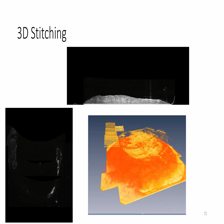

###################################################################
Question:  what is there in this slide?
Predicted Answer:  the transcript suggests that if the derivative operator is too complex, it may not be suitable for implementing
Actual Answer:  various distance or similarity measures offer alternative ways to quantify dissimilarity or similarity between data instances. one such measure is the minkowski metric


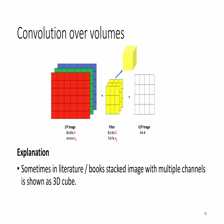

###################################################################
Question:  how are the concepts discussed related to the dimensions of space?
Predicted Answer:  the discussion on distance metrics may have implications or applications for mathematical analysis, particularly in the context
Actual Answer:  the concepts discussed in the transcript are related to the dimensions of space, particularly in cases involving 2d or 3d space. the dimensions play a crucial role in


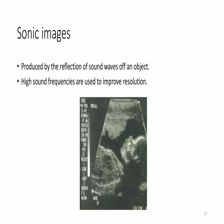

###################################################################
Question:  what does the speaker suggest about the outcome of'trying to improve'the image?
Predicted Answer:  the speaker proposes increasing the'supply and power'function of the image, possibly referring to its
Actual Answer:  the speaker suggests that attempting to improve the image through processing will result in a noticeable change or enhancement.


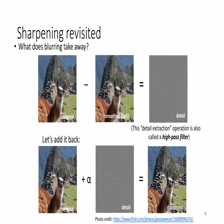

###################################################################
Question:  what is recommended to achieve the proposed solution?
Predicted Answer:  to improve the spread of gaussian functions, it is suggested to minimizes the spread of
Actual Answer:  to achieve the proposed solution, it is recommended to have higher values in the center and lower values at the edges.


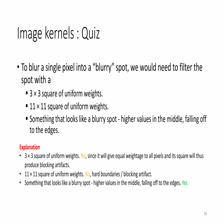

###################################################################
Question:  what future developments might improve the performance of mdp - based helicopter control?
Predicted Answer:  future developments could include advanced algorithms that adjust the state - of - the - art segmentation model
Actual Answer:  future developments might include integrating more advanced machine learning techniques to better predict state transitions, enhancing sensor technologies for more accurate data, and developing more sophisticated noise models


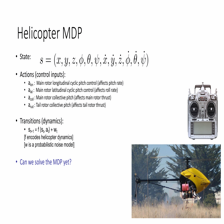

###################################################################
Question:  create a fictional scenario describing a student's confusion about the function'g'and a teacher clarifying it.
Predicted Answer:  as a student, i would begin by understanding the practical principles of g - cnn, i would
Actual Answer:  a student, puzzled about the'g'function in the residual block diagram, asks,'does'g'modify the input data directly? '


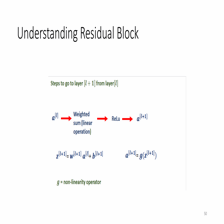

###################################################################
Question:  how does the result'inferred sequence is much cleaner'relate to the objectives of trajectory analysis?
Predicted Answer:  the outcome of the outcome in transfer learning is a more effective and suitable for future developments in the
Actual Answer:  the cleaner inferred sequence indicates a successful alignment of noisy or varied data into a more coherent and consistent trajectory, which is crucial for understanding the underlying


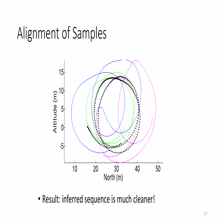

###################################################################
Question:  what are some potential strategies to enhance the performance of recommender systems given the sparse nature of user / item matrices?
Predicted Answer:  strategies could include incorporating more efficient network architectures, incorporating adaptive user feedback techniques, or incorporating adaptive
Actual Answer:  potential strategies include incorporating additional user and item features, utilizing hybrid recommendation approaches, implementing matrix factorization techniques, and leveraging contextual information to make more


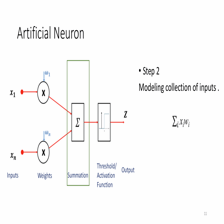

###################################################################
Question:  can you provide more details about the image mentioned in the context?
Predicted Answer:  in the context of the image gradient, the relationship between the distribution of unsharp masking
Actual Answer:  the image features both a dog and a woman with the same hairstyle, serving as an example of similarity within the context of clustering.


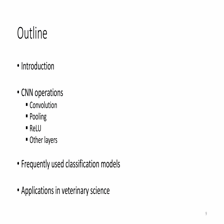

###################################################################
Question:  what are some examples of masks discussed in the lecture?
Predicted Answer:  in lecture 7, the discussed masks are used for gradient masks, as well as other effective masks
Actual Answer:  the lecture discusses various masks, including sobel and prewitt masks, for edge detection. these masks are designed for x and y directions to capture


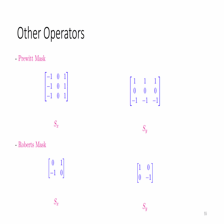

###################################################################
Question:  can you provide an analogy to illustrate the concept of the hysteresis threshold in edge detection?
Predicted Answer:  an hysteresis threshold can be used in edge detection to identify edges or features in an
Actual Answer:  imagine a team of detectives investigating a crime scene. each detective specializes in identifying specific types of evidence, with some focused on strong clues and others on subtle


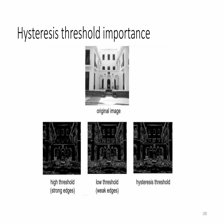

###################################################################
Question:  what components are mentioned in relation to the x - flip operation?
Predicted Answer:  h1, or the derivative of'x ', is mentioned in the transcript as a part
Actual Answer:  h1, h2, and h3 are mentioned in relation to the x - flip operation.


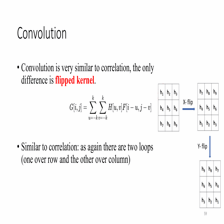

###################################################################
Question:  what are some purposes of filtering?
Predicted Answer:  in filtering an impulse signal, dilation the input matrix, such as unpooling, can
Actual Answer:  filtering can be used to emphasize features such as motion sharpening and edge enhancement, as well as to remove features like noise.


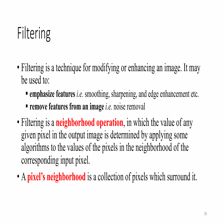

###################################################################
Question:  discuss the impact of residual connections on the training dynamics of vision transformers.
Predicted Answer:  residual connections benefit the vision transformer by allowing the network to learn more complex patterns in data aug
Actual Answer:  residual connections impact the training dynamics of vision transformers by ensuring that the learning signals can be effectively propagated back through the network, even across many layers


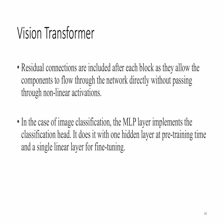

###################################################################
Question:  what key points are highlighted in the transcript regarding image processing and operations?
Predicted Answer:  the transcript emphasizes the importance of overall feature extraction in image processing, including more effective convolu
Actual Answer:  the transcript highlights key discussions on image processing, operations, contrasting effects, and potential outcomes.


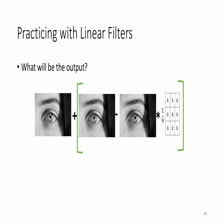

###################################################################
Question:  what technique was suggested instead of using the average of pixel values in the neighborhood?
Predicted Answer:  in the broader field of computer vision, the use of median filtering instead of treating nearby pixels equally
Actual Answer:  using the median value of pixel values in the neighborhood was suggested as an alternative to using the average.


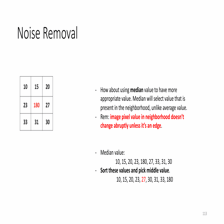

###################################################################
Question:  what does the transcript suggest about the recoverability of the original image?
Predicted Answer:  the transcript suggests that even if the function of eta is greater than the input, it may not
Actual Answer:  the transcript suggests that even if the function of eta is known, the original image may still not be recoverable because additive noise may destroy the information.


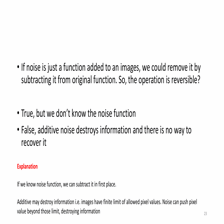

###################################################################
Question:  what is the difference between batch normalization and dropout in neural networks?
Predicted Answer:  gradient descent, particularly in the context of regularization, is used in refinement clustering
Actual Answer:  batch normalization helps stabilize neural network training by normalizing inputs to layers. dropout is a regularization technique that involves randomly dropping out neurons during training


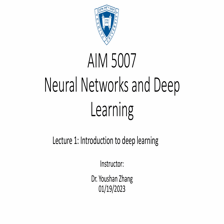

###################################################################
Question:  how is noise removal described in the transcript?
Predicted Answer:  noise removal is considered beneficial in the gaussian period, where it may not always be more
Actual Answer:  the transcript describes noise removal by averaging pixel values.


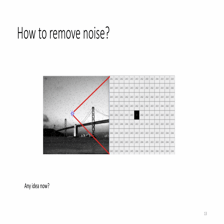

###################################################################
Question:  what is there in this slide?
Predicted Answer:  the transcript suggests that if the derivative operator is too independent and closely related to the data, it
Actual Answer:  in this overview of machine learning concepts, we explore various methods for matrix factorization. we start with the motivation behind matrix factorization techniques, highlighting their


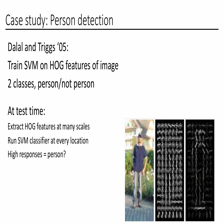

###################################################################
Question:  describe the input and output relationship in segnet.
Predicted Answer:  in lenet - 5, the output feature map can be categorized into two classes, where the
Actual Answer:  in segnet, the input is a standard rgb image, and the output is a segmentation map where each pixel is classified into one of


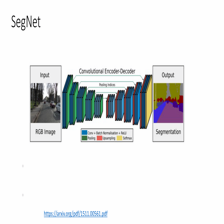

###################################################################
Question:  what are the implications of a large positive covariance between two dimensions?
Predicted Answer:  a two - dimensional vector can be used for more comprehensive filtering, where it does not allow for
Actual Answer:  a large positive covariance suggests that the two dimensions tend to increase or decrease together, indicating a positive relationship between them.


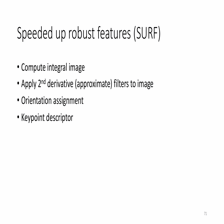

###################################################################
Question:  what role does the laplacian operator play in zero crossing detection?
Predicted Answer:  the laplacian of gaussian ( log ) operator is used in edge detection to better
Actual Answer:  the laplacian operator is used to compute the second derivative of the image, highlighting areas of rapid intensity change or gradient discontinuities. by


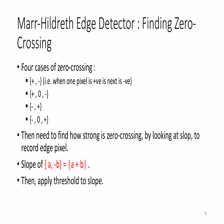

###################################################################
Question:  what term is used to describe the process of looping over all pixels in the neighborhood?
Predicted Answer:  the term'overlaying the input image with the input pixel'is used to describe the
Actual Answer:  the term'looping over all pixels in the neighborhood'is used to describe the process discussed in the transcript.


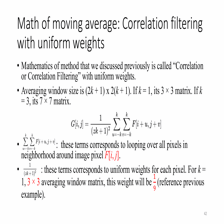

###################################################################
Question:  how is the reward function structured for helicopter hovering?
Predicted Answer:  the reward function is calculated as a pre - trained model for transfer learning, where it is used
Actual Answer:  the reward function is structured as a series of penalties for deviation from desired spatial coordinates ( x, y, z ) and excessive velocities (


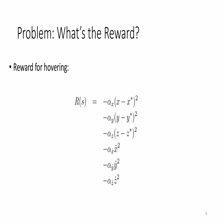

###################################################################
Question:  generate a metaphor to explain the role of the region proposal network in faster r - cnn.
Predicted Answer:  in faster r - cnn, the region proposal network ( rpn ) acts as a feature
Actual Answer:  the region proposal network ( rpn ) in faster r - cnn acts like a scout. just as a scout surveys the terrain and identifies key areas


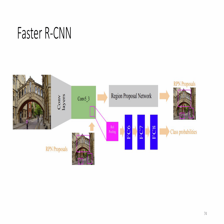

###################################################################
Question:  how important is image quality in the detection procedure for accurate results?
Predicted Answer:  in image refinement, the suitability of the standard deviation, as shown in the graph
Actual Answer:  image quality is very important ; higher resolution and clear imagery can greatly improve the accuracy of the detection, especially for fine details and small or distant objects.


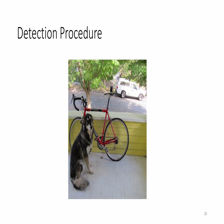

###################################################################
Question:  how do the visual aids on the slide help in understanding the effect of relu on 1x1 convolution outputs?
Predicted Answer:  the visual aids used to enhance the accuracy of the 1x1 convolution filters by
Actual Answer:  the visual aids on the slide help by showing the before and after effects of applying relu to the outputs from 1x1 convolutions.


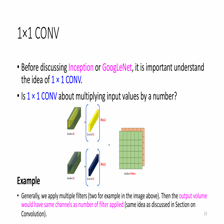

###################################################################
Question:  what advice is provided regarding the proposed solution?
Predicted Answer:  the objective function of implementing the partial derivative with respect, as described, is to enhance the performance
Actual Answer:  the advice given is to have higher values in the center and lower values towards the edges in the proposed solution.


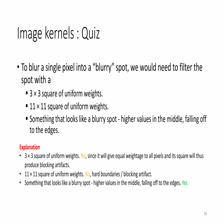

###################################################################
Question:  how does a threshold filter contribute to image segmentation?
Predicted Answer:  a threshold filter contributess to image segmentation by providing a simple method for simplifying the
Actual Answer:  a threshold filter simplifies image segmentation by converting grayscale images into binary outputs, facilitating the isolation of objects or features based on prede


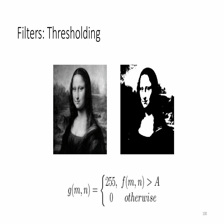

###################################################################
Question:  what is caution filtering and when may it not effectively remove noise?
Predicted Answer:  gradient descent, or unpredictability, is considered beneficial in filtering techniques, where it does
Actual Answer:  caution filtering is a method used to remove noise in images, but it may not be effective if there are significant amounts of noise present, particularly thousands of


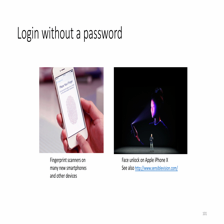

###################################################################
Question:  how does canny's method utilize gradient direction to inform edge detection?
Predicted Answer:  gradient descent, where if there is a convolutional layer on the edge of a
Actual Answer:  canny's method utilizes gradient direction to inform edge detection by examining patterns in neighborhood pixels. the gradient direction, also known as the direction of the


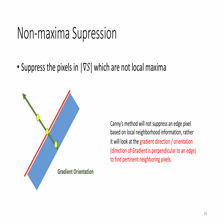

###################################################################
Question:  what is the function of pixelwise output and loss in the network?
Predicted Answer:  in the network architecture, output convolutional operations, such as max pooling,
Actual Answer:  pixelwise output ensures that each pixel in the input image is classified into a category, making it suitable for segmentation tasks. the loss function measures the


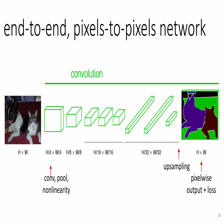

###################################################################
Question:  brainstorm potential collaborations between image processing experts and practitioners from other fields to explore novel applications of image kernels.
Predicted Answer:  consider applications involving image processing, such as different kernel sizes, adaptive filtering techniques, and adaptive threshold
Actual Answer:  consider interdisciplinary collaborations with professionals from fields such as healthcare, environmental science, architecture, and entertainment.


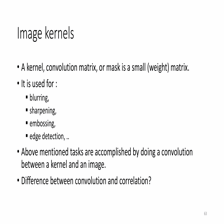

###################################################################
Question:  what is the primary objective of clustering as described in the context?
Predicted Answer:  the primary objective of hierarchical clustering is to provide a more comprehensive analysis of data points in various
Actual Answer:  the primary objective of clustering is to find clusters within a set of data points, maximizing inter - cluster similarity while minimizing intra - cluster


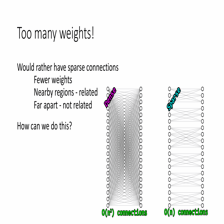

###################################################################
Question:  what term does the speaker use to describe the behavior of the blue line?
Predicted Answer:  the speaker describes the blue line as uniform.
Actual Answer:  the speaker describes the behavior of the blue line as uniform.


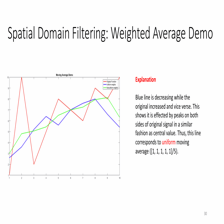

###################################################################
Question:  can you explain how the equation b * = arg min b st. rank ( b ) = k | | xb | | relates to dimensional
Predicted Answer:  b = is expressed as b = = / b, where b represents the number of singular values
Actual Answer:  it represents the process of reducing the dimensionality of the data by approximating the original matrix x with a lower - rank matrix b *.


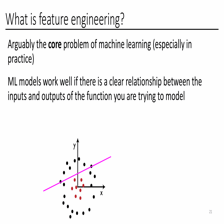

###################################################################
Question:  what is the role of the dense layers in vgg - 16?
Predicted Answer:  in the dense layer architecture, the fcn layer is used as the covariance threshold,
Actual Answer:  the dense layers in vgg - 16, located at the end of the network, are responsible for making the final decisions. after receiving processed features from


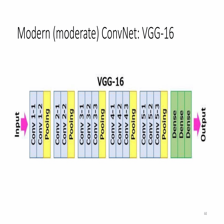

###################################################################
Question:  what role does visible light play in human vision?
Predicted Answer:  human vision transformer, like those in the vision transformer, can handle the broader field of
Actual Answer:  visible light plays a fundamental role in human vision as it enables the human eye to detect and perceive the surrounding environment. by interacting with photorecept


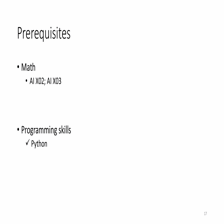

###################################################################


In [20]:
for x in range(100):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")

In [21]:
import torch
from torch.nn.functional import normalize

def cosine_similarity(tensor1, tensor2):
    """
    Compute the cosine similarity between two tensors.
    """
    tensor1_normalized = normalize(tensor1, p=2, dim=-1)
    tensor2_normalized = normalize(tensor2, p=2, dim=-1)
    return (tensor1_normalized * tensor2_normalized).sum(dim=-1)


In [22]:
from tqdm.notebook import tqdm

cosine_similarities = []

# Assuming 'test_dataloader' is defined similarly to your 'val_dataloader'
for batch in tqdm(val_dataloader):
    sample = {k: v.to(device) for k, v in batch.items()}

    # Forward pass to generate outputs
    outputs = model.generate(
        input_ids=sample['input_ids'],
        pixel_values=sample['pixel_values'],
        attention_mask=sample['attention_mask'],
        max_length=sample['labels'].size(1)  # Ensure generated length matches labels length
    )

    # Assuming outputs are in the same device as labels
    # Here, labels and outputs are both tensors of token IDs
    labels = sample['labels']

    # Convert token IDs to embeddings or another form suitable for cosine similarity
    # This step is skipped in this example for simplicity

    # Compute cosine similarity for each item in the batch
    for idx in range(outputs.size(0)):
        cos_sim = cosine_similarity(outputs[idx].unsqueeze(0).float(), labels[idx].unsqueeze(0).float())
        cosine_similarities.append(cos_sim.item())

# Display the computed similarities
print("Cosine Similarities:", cosine_similarities)


  0%|          | 0/135 [00:00<?, ?it/s]

Cosine Similarities: [0.754626989364624, 0.4636739194393158, 0.34813421964645386, 0.48224812746047974, 0.5701062679290771, 0.2669050097465515, 0.4897432327270508, 0.355343222618103, 0.5366661548614502, 0.3850064277648926, 0.32719117403030396, 0.5550015568733215, 0.27411043643951416, 0.5493598580360413, 0.3059646189212799, 0.35031381249427795, 0.3718408942222595, 0.4272131323814392, 0.27699217200279236, 0.22197039425373077, 0.4847893714904785, 0.40406474471092224, 0.3240010738372803, 0.36889907717704773, 0.3248303234577179, 0.3018583059310913, 0.22287483513355255, 0.5217074155807495, 0.31185612082481384, 0.4881402254104614, 0.5615735650062561, 0.8883277773857117, 0.46401047706604004, 0.5459555387496948, 0.27018749713897705, 0.39108365774154663, 0.4578895568847656, 0.2707272171974182, 0.5730822086334229, 0.7644875049591064, 0.700832188129425, 0.34249094128608704, 0.2513807415962219, 0.7754758596420288, 0.46359917521476746, 0.5121009349822998, 0.39067646861076355, 0.27381908893585205, 0.3

In [23]:
# Calculate the average of the cosine similarity scores
avg_cosine_similarity = np.mean(cosine_similarities)

# Print the average cosine similarity
print("Average Cosine Similarity on Test Data:", avg_cosine_similarity)


Average Cosine Similarity on Test Data: 0.42092494621907395


In [24]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


In [25]:
# Prepare your data and model
# Assuming test_dataloader is already defined and model is loaded

# Store all the candidate and reference sentences
candidates = []
references = []

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model.generate(**inputs)

        # Decode the output indices to strings
        generated_texts = [text_processor.decode(g, skip_special_tokens=True) for g in outputs]
        actual_texts = [text_processor.decode(l, skip_special_tokens=True) for l in batch['labels']]

        # Add the generated and actual texts to their respective lists
        candidates.extend([[tok for tok in gen.split()] for gen in generated_texts])
        references.extend([[[tok for tok in act.split()]] for act in actual_texts])  # Note the double list for references

# Calculate BLEU score
chencherry = SmoothingFunction()
score = corpus_bleu(references, candidates, smoothing_function=chencherry.method1)

print(f"BLEU score: {score}")


  0%|          | 0/135 [00:00<?, ?it/s]

BLEU score: 0.10938534096029585


In [26]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [27]:
pip install rouge-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=132a95bf33f79f862f255f90f95cbec1d0b80f65151e7608dee554ddf9bcff46
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [28]:
from rouge_score import rouge_scorer
from tqdm.notebook import tqdm

# Prepare your data and model
# Assuming test_dataloader is already defined and model is loaded

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store all scores
scores_rouge1 = []
scores_rouge2 = []
scores_rougeL = []

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model.generate(**inputs)

        # Decode the output indices to strings
        generated_texts = [text_processor.decode(g, skip_special_tokens=True) for g in outputs]
        actual_texts = [text_processor.decode(l, skip_special_tokens=True) for l in batch['labels']]

        # Calculate ROUGE scores for each pair of generated and actual text
        for gen_text, act_text in zip(generated_texts, actual_texts):
            score = scorer.score(act_text, gen_text)
            scores_rouge1.append(score['rouge1'].fmeasure)
            scores_rouge2.append(score['rouge2'].fmeasure)
            scores_rougeL.append(score['rougeL'].fmeasure)

# Calculate average scores
avg_rouge1 = sum(scores_rouge1) / len(scores_rouge1)
avg_rouge2 = sum(scores_rouge2) / len(scores_rouge2)
avg_rougeL = sum(scores_rougeL) / len(scores_rougeL)

print(f"Average ROUGE-1 score: {avg_rouge1}")
print(f"Average ROUGE-2 score: {avg_rouge2}")
print(f"Average ROUGE-L score: {avg_rougeL}")


  0%|          | 0/135 [00:00<?, ?it/s]

Average ROUGE-1 score: 0.37835773307695975
Average ROUGE-2 score: 0.18384946598596882
Average ROUGE-L score: 0.32753875712715513
